# User agent analysis

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

In [3]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [4]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

In [5]:
def yeh(ua, dev):
    if ua in useragents[dev]: return 1
    return 0

datas = [ [ yeh(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)

In [6]:
df["score"] = df.sum(axis=1)
df = df.sort_values(by="score", ascending=False)
df

,LAPTOP-1I501C4U,dramatic-mac,terrestrial-mac,languid-mac,mark-mac,calcannea-cb,calcannea-mac,nervings-cb,simon-macpro,misskitty-mac,...,steamverne-mac,rarb-mac,theatergoing-mac,abroad-android,turing-chromebook,traverses-mac,essential-mac,essential-chrome,daniel-chromebook,score
Mozilla/5.0 (Macintosh; Intel,0,1,1,1,1,0,1,0,1,1,...,1,1,1,0,1,1,0,0,0,18
trustd (unknown version) CFNet,0,1,1,1,1,0,0,0,1,1,...,1,1,1,0,1,1,1,0,0,18
Software%20Update (unknown ver,0,1,0,1,1,0,0,0,1,1,...,1,1,1,0,0,1,0,0,0,13
GoogleSoftwareUpdate/1.2.10.10,0,1,1,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,8
mobileassetd (unknown version),0,1,1,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,8
Mac OS X/10.13.5 (17F77),0,0,1,1,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,8
com.apple.trustd/1.0,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7
ocspd/1.0.3,0,0,1,0,0,0,0,0,0,1,...,1,0,1,0,0,1,0,0,0,7
Mozilla/5.0 (X11; CrOS x86_64,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,1,6
MacAppStore/2.4 (Macintosh; OS,0,1,1,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,6


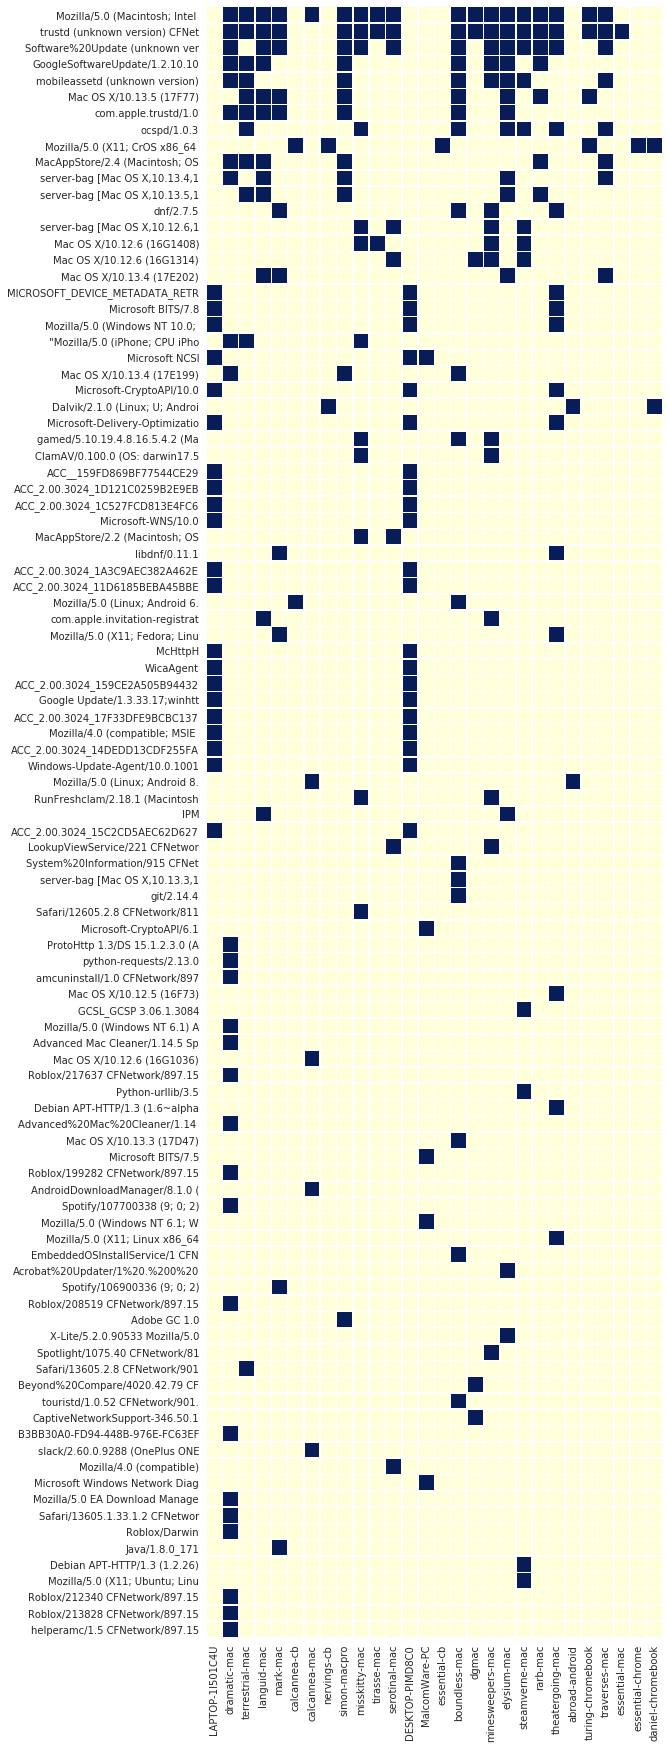

In [8]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df[all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()